In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


/home/yosh/gradio-demo/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

In [ ]:
dataset = load_dataset("Xenova/quickdraw-small")

# could be used for data-augmentation
preprocess = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0,), (1,))  
])

def preprocess_ops(examples):
    examples['image'] = [preprocess(image) for image in examples['image']]
    return examples

dataset.set_transform(preprocess_ops)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4500000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 250000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 250000
    })
})

In [ ]:
train_dataset, test_dataset, val_dataset = dataset['train'], dataset['test'], dataset['valid']
train_dataset = train_dataset.shard(num_shards=10, index=0)
names = train_dataset.features['label'].names
n_classes = len(names)

print(f'trainset size {len(train_dataset)}')

trainset size 450000


In [ ]:
import json

with open('labels.json', 'w') as f:
    json.dump(names, f)

In [ ]:
def id_to_class(idx):
    return names[idx]

label spider


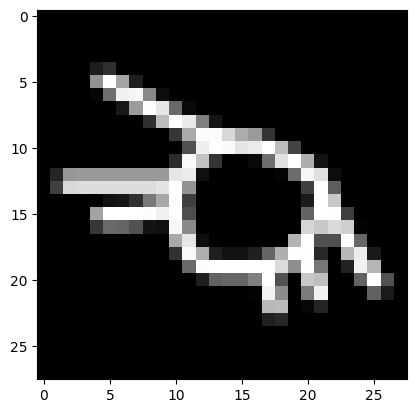

In [ ]:

idx = torch.randint(0, 100, (1,))
img, label = test_dataset[idx]['image'], test_dataset[idx]['label']
img = img[0].squeeze(dim=0)
print(f'label {id_to_class(label[0])}')
plt.imshow(img, cmap='gray')

## DataLoader

In [ ]:
from cnn import CNN # type: ignore

params = {
    'n_filters': 30,
    'hidden_dim': 100,
    'n_layers': 2,
    'n_classes': n_classes
}
model = CNN(**params).to(device)
n_params = sum([p.numel() for p in model.parameters()])
print(f'Number of params {n_params}')

Number of params 197385


In [ ]:
# hyperparameters
lr = 0.001
batch_size = 128*4
n_epochs = 1

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

trainLoader, testLoader = DataLoader(train_dataset, batch_size=batch_size), DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
def train(model, trainLoader, testLoader, criterion, optimizer, n_epochs):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    for epoch in range(1, n_epochs+1):
        model.train()
        train_loss = 0
        train_acc = 0
        for batch in tqdm(trainLoader):
            data, labels = batch['image'], batch['label']
            out = model(data)
            preds = out.argmax(dim=1)
            loss = criterion(out, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (preds == labels).sum().item()

        train_loss /= len(trainLoader)
        train_acc /= len(trainLoader.dataset)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        test_acc = 0
        with torch.no_grad():
            for batch in tqdm(testLoader, disable=True):
                data, labels = batch['image'], batch['label']
                out = model(data)
                loss = criterion(out, labels)
                preds = out.argmax(dim=1)
                test_loss += loss.item()
                test_acc += (preds == labels).sum().item()

        test_loss /= len(testLoader)
        test_acc /= len(testLoader.dataset)
        test_accs.append(test_acc)
        test_losses.append(test_loss)

        print(f'epoch {epoch} | train loss {train_loss:.3f} train acc {train_acc:.2f} | test loss {test_loss:.3f} test acc {test_acc:.2f}')
    return train_losses, train_accs, test_losses, test_accs


In [ ]:
train_losses, train_accs, test_losses, test_accs = train(model, trainLoader, testLoader, criterion, optimizer, n_epochs)

100%|██████████| 1758/1758 [03:07<00:00,  9.37it/s]


epoch 1 | train loss 3.754 train acc 0.21 | test loss 2.756 test acc 0.39


100%|██████████| 1758/1758 [02:58<00:00,  9.88it/s]


epoch 2 | train loss 2.980 train acc 0.33 | test loss 2.439 test acc 0.44


In [ ]:
if max(test_accs) > 0.8:
    torch.save(model.state_dict(), 'weights/cnn.pth')

Validation
---

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from gradio_demo.model.utils import get_validation_metrics

# def get_validation_metrics(model, val_dataset, batch_size, criterion, device):
#     valLoader = DataLoader(val_dataset, batch_size=batch_size)
#     all_preds, all_labels = [], []
#     val_loss, val_acc = 0, 0
#     model.eval()
#     with torch.no_grad():
#         for batch in tqdm(valLoader):
#             data, labels = batch['image'].to(device), batch['label'].to(device)
#             out = model(data)
#             loss = criterion(out, labels)
#             preds = out.argmax(dim=1)
#             val_loss += loss.item()
#             val_acc += (preds == labels).sum().item()
#             all_preds.extend(preds.detach().cpu().numpy())
#             all_labels.extend(labels.detach().cpu().numpy())

#         val_loss /= len(valLoader)
#         val_acc /= len(valLoader.dataset)

#     precision, recall, f1, _ = precision_recall_fscore_support(
#         all_labels, all_preds, average='weighted'  # or 'weighted' depending on your preference
#     )
#     metrics = {
#         'loss': val_loss,
#         'accuracy': val_acc,
#         'precision': precision,
#         'recall': recall,
#         'f1_score': f1
#     }
#     return metrics

val_metrics = get_validation_metrics(model, val_dataset, batch_size=256, criterion=criterion, device=device)

Validating:  16%|█▌        | 153/977 [00:06<00:37, 22.05it/s]


KeyboardInterrupt: 

In [21]:
for k, v in val_metrics.items():
    print(f'{k}: {v:0.3f}')

validation_loss: 2.439
validation_accuracy: 0.442
precision: 0.459
recall: 0.442
f1_score: 0.423
